In [1]:
import os
import glob
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
from os import listdir, makedirs, getcwd, remove
from os import path
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import cv2


%matplotlib inline

print(os.listdir())

['Baseline_final_project.ipynb', 'chest_xray']


In [2]:
data_dir = Path('chest_xray')

In [3]:
train_dir = data_dir / 'train'
val_dir = data_dir / 'val'
test_dir = data_dir / 'test'

In [4]:
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')


train_data = []

# Normal cases - label: 0
for img in normal_cases:
    train_data.append((img,0))

# Normal cases - label: 1
for img in pneumonia_cases:
    train_data.append((img, 1))

train_data = pd.DataFrame(
    train_data, 
    columns = ['image', 'label'],
    index = None
)

# Shuffle 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

train_data.head()

,image,label
0,chest_xray\train\PNEUMONIA\person841_bacteria_...,1
1,chest_xray\train\PNEUMONIA\person1087_bacteria...,1
2,chest_xray\train\PNEUMONIA\person1338_virus_23...,1
3,chest_xray\train\NORMAL\NORMAL2-IM-0986-0001.jpeg,0
4,chest_xray\train\PNEUMONIA\person1346_virus_23...,1


1    3875
0    1341
Name: label, dtype: int64


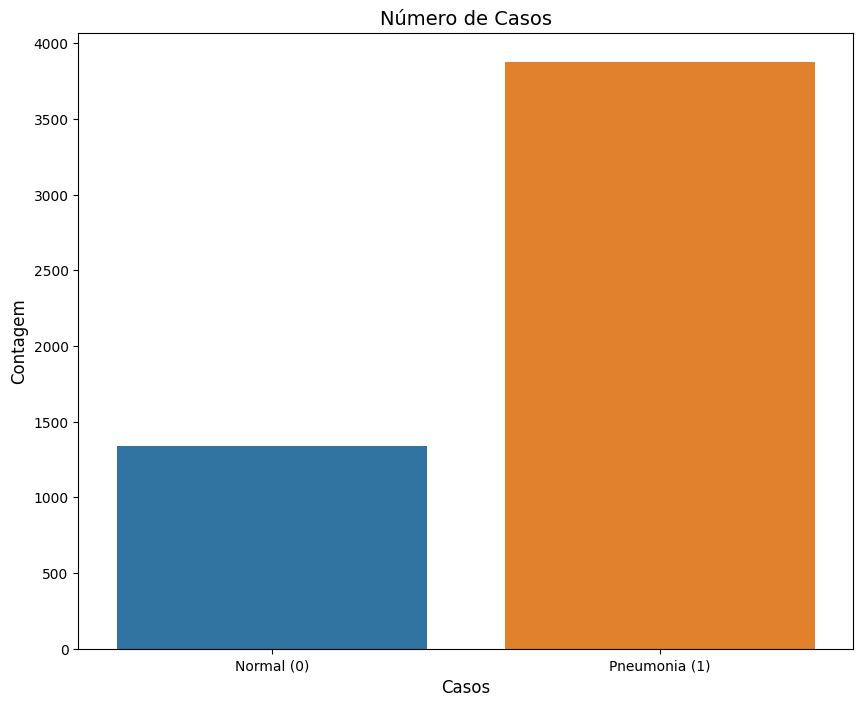

In [5]:
cases_count = train_data['label'].value_counts()
print(cases_count)

plt.figure(figsize = (10,8))
sns.barplot(x = cases_count.index, y = cases_count.values)
plt.title('Número de Casos', fontsize=14)
plt.xlabel('Casos', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal (0)', 'Pneumonia (1)'])
plt.show()

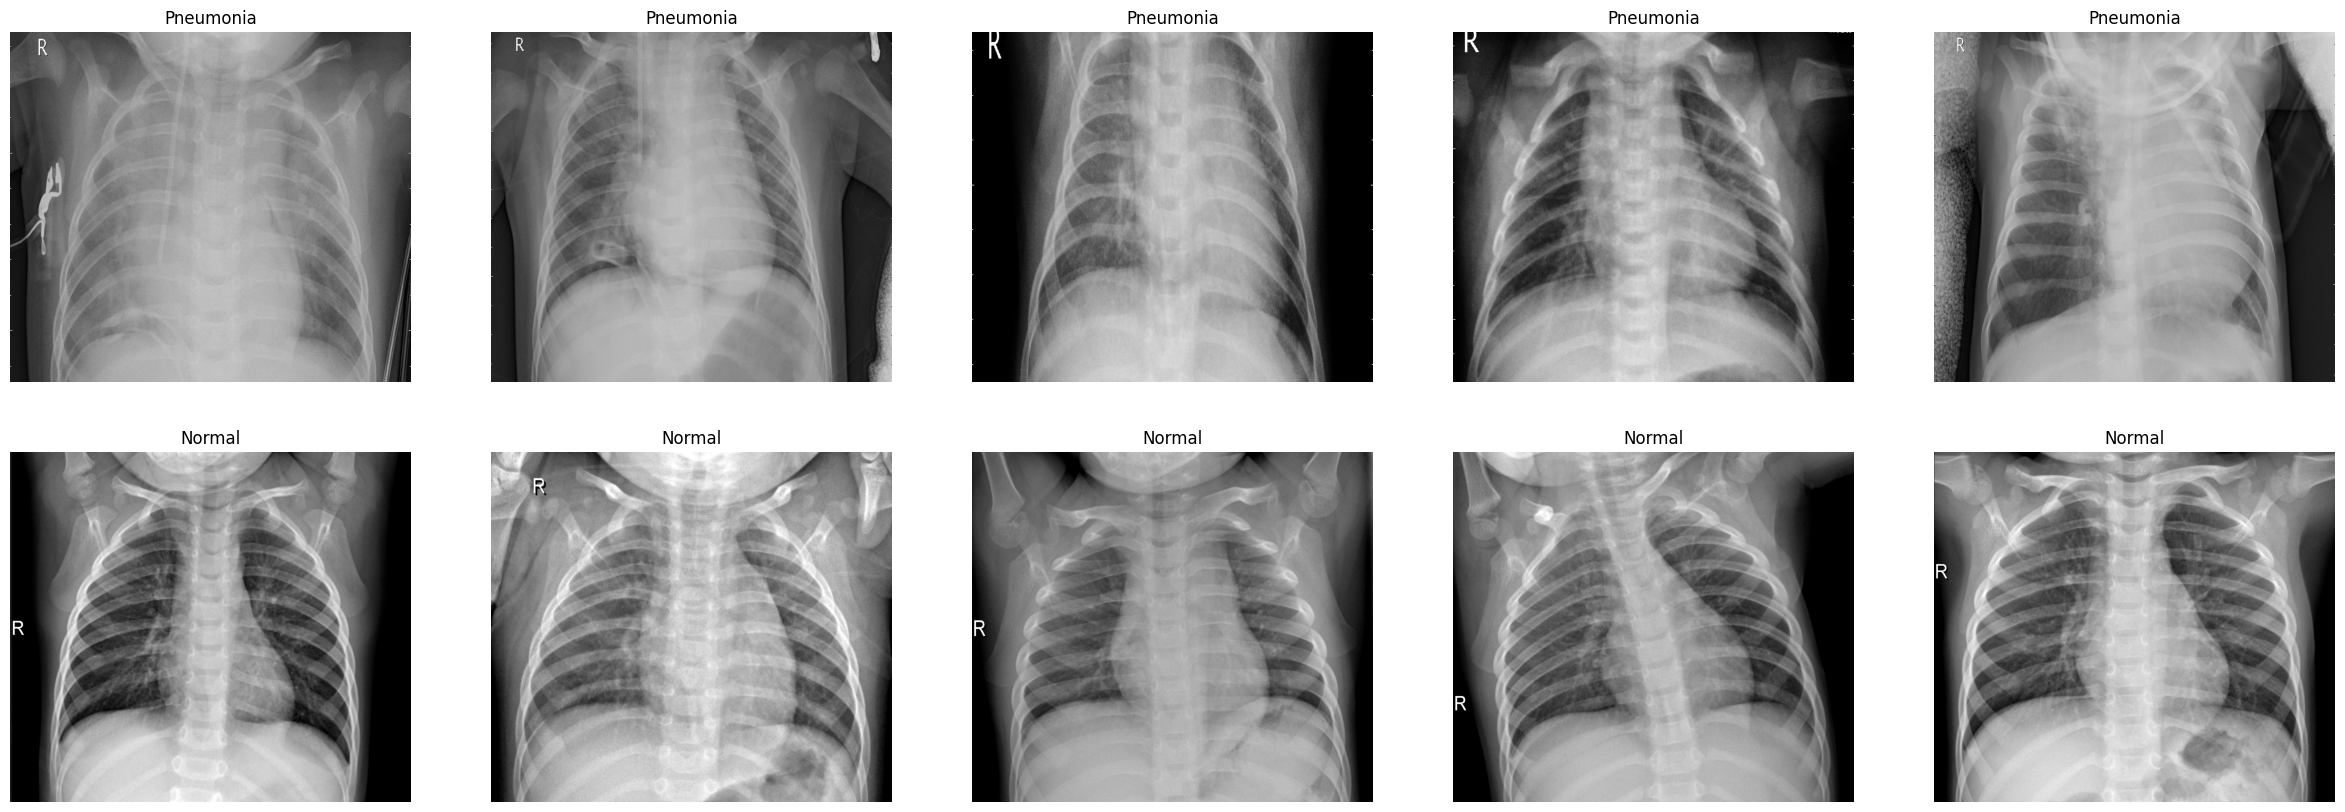

In [6]:
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

In [7]:
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

x_train_bs = []
y_train_bs = []


# Deixando na dim 224 x 224

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224)).astype(np.float32)
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    label = to_categorical(0, num_classes = 2)
    x_train_bs.append(img)
    y_train_bs.append(label)
                      
# Pneumonia cases        
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224)).astype(np.float32)
    if img.shape[2] == 1:
        img = np.dstack([img, img, img])
    label = to_categorical(1, num_classes = 2)
    x_train_bs.append(img)
    y_train_bs.append(label)
    
x_train_bs = np.array(x_train_bs)
y_train_bs = np.array(y_train_bs)

In [8]:
x_train_bs.shape, y_train_bs.shape

((5216, 224, 224, 3), (5216, 2))

In [9]:
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

x_val_bs = []
y_val_bs = []

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224)).astype(np.float32)
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    label = to_categorical(0, num_classes = 2)
    x_val_bs.append(img)
    y_val_bs.append(label)
                      
# Pneumonia cases        
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224)).astype(np.float32)
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    label = to_categorical(1, num_classes=2)
    x_val_bs.append(img)
    y_val_bs.append(label)
    
x_val_bs = np.array(x_val_bs)
y_val_bs = np.array(y_val_bs)

In [10]:
x_val_bs.shape, y_val_bs.shape

((16, 224, 224, 3), (16, 2))

In [11]:
cnn_bs = tf.keras.models.Sequential()

cnn_bs.add(Conv2D(filters = 32, kernel_size = 3, activation = 'relu'))
cnn_bs.add(Input(shape=(64, 64, 3)))
cnn_bs.add(MaxPooling2D(pool_size = 2, strides = 2))
cnn_bs.add(Flatten())
cnn_bs.add(Dense(units = 128, activation = 'relu'))
cnn_bs.add(Dense(units = 2, activation = 'sigmoid'))

In [12]:
cnn_bs.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

hist_bs = cnn_bs.fit(
    x_train_bs,
    y_train_bs, 
    epochs = 10, 
    validation_data = (x_val_bs, y_val_bs)
)

Epoch 1/10
163/163 [==============================] - 59s 362ms/step - loss: 162.6193 - accuracy: 0.9105 - val_loss: 8.7126 - val_accuracy: 0.8125
Epoch 2/10
163/163 [==============================] - 88s 544ms/step - loss: 0.9359 - accuracy: 0.9852 - val_loss: 1.8393 - val_accuracy: 0.9375
Epoch 3/10
163/163 [==============================] - 76s 465ms/step - loss: 0.4251 - accuracy: 0.9946 - val_loss: 8.7762 - val_accuracy: 0.8125
Epoch 4/10
163/163 [==============================] - 58s 356ms/step - loss: 0.1615 - accuracy: 0.9975 - val_loss: 1.1422 - val_accuracy: 0.9375
Epoch 5/10
163/163 [==============================] - 56s 346ms/step - loss: 0.2358 - accuracy: 0.9965 - val_loss: 4.1776 - val_accuracy: 0.8750
Epoch 6/10
163/163 [==============================] - 57s 348ms/step - loss: 0.1604 - accuracy: 0.9979 - val_loss: 1.4725 - val_accuracy: 0.9375
Epoch 7/10
163/163 [==============================] - 57s 349ms/step - loss: 0.2154 - accuracy: 0.9958 - val_loss: 13.3932 - val

In [13]:
def history_plot(history, title):
    plt.figure(figsize=(11,4))
    plt.subplot(1, 2, 1)
    plt.suptitle(title, fontsize=15)
    plt.xlabel("Número de Épocas")
    plt.ylabel('Loss', fontsize=12)
    plt.plot(history.history['loss'], color='r', label = 'Training-Loss')
    plt.plot(history.history['val_loss'], color='g', label = 'Val-Loss')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.ylabel('Acurácia', fontsize=12)
    plt.xlabel("Número de Épocas")
    plt.ylabel('Loss', fontsize=12)
    plt.plot(history.history['accuracy'], color='r', label='Training-Acc')
    plt.plot(history.history['val_accuracy'], color='g', label='Val-Acc')
    plt.legend(loc='best')
    plt.show()

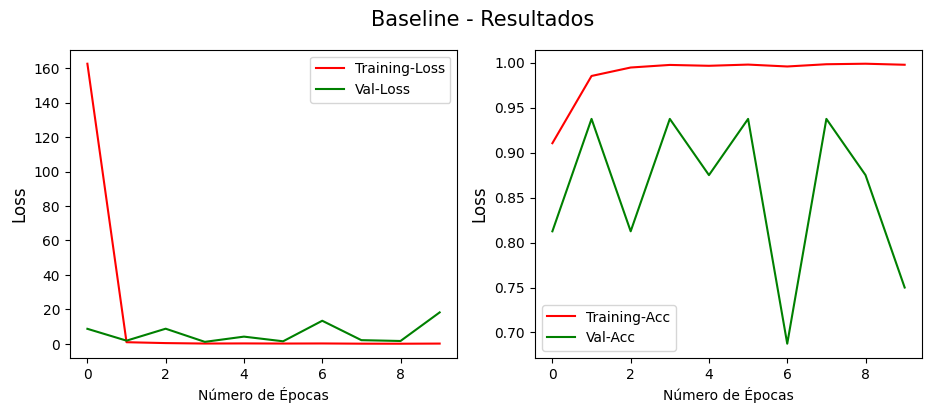

In [20]:
history_plot(hist_bs, 'Baseline - Resultados')

In [15]:
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

x_train = []
y_train = []


# Deixando na escala de 3 canais (algumas estavam na escala de cinza, mas a maioria nao) e padronizando pelo max (255)

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes = 2)
    x_train.append(img)
    y_train.append(label)
                      
# Pneumonia cases        
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] == 1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes = 2)
    x_train.append(img)
    y_train.append(label)

x_train = np.array(x_train)
y_train = np.array(y_train)

In [16]:
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

x_val = []
y_val = []

# Deixando na escala de 3 canais (algumas estavam na escala de cinza, mas a maioria nao) e padronizando pelo max (255)

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes = 2)
    x_val.append(img)
    y_val.append(label)
                      
# Pneumonia cases        
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    x_val.append(img)
    y_val.append(label)
    
x_val = np.array(x_val)
y_val = np.array(y_val)

In [17]:
m1 = tf.keras.models.Sequential()

m1.add(Conv2D(filters = 32, kernel_size = 3, activation = 'relu'))
m1.add(Input(shape=(64, 64, 3)))
m1.add(MaxPooling2D(pool_size = 2, strides = 2))
m1.add(Flatten())
m1.add(Dense(units = 128, activation = 'relu'))
m1.add(Dense(units = 2, activation = 'sigmoid'))

m1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

hist_m1 = m1.fit(
    x_train,
    y_train, 
    epochs = 10, 
    validation_data = (x_val, y_val)
)

Epoch 1/10
163/163 [==============================] - 57s 347ms/step - loss: 1.1373 - accuracy: 0.8740 - val_loss: 0.4052 - val_accuracy: 0.7500
Epoch 2/10
163/163 [==============================] - 57s 350ms/step - loss: 0.0917 - accuracy: 0.9701 - val_loss: 0.2861 - val_accuracy: 0.8750
Epoch 3/10
163/163 [==============================] - 57s 347ms/step - loss: 0.0626 - accuracy: 0.9808 - val_loss: 0.1850 - val_accuracy: 0.9375
Epoch 4/10
163/163 [==============================] - 55s 340ms/step - loss: 0.0351 - accuracy: 0.9908 - val_loss: 0.1400 - val_accuracy: 0.9375
Epoch 5/10
163/163 [==============================] - 56s 342ms/step - loss: 0.0262 - accuracy: 0.9954 - val_loss: 0.3574 - val_accuracy: 0.8125
Epoch 6/10
163/163 [==============================] - 55s 339ms/step - loss: 0.0238 - accuracy: 0.9954 - val_loss: 0.1419 - val_accuracy: 0.9375
Epoch 7/10
163/163 [==============================] - 55s 337ms/step - loss: 0.0118 - accuracy: 0.9990 - val_loss: 0.0937 - val_ac

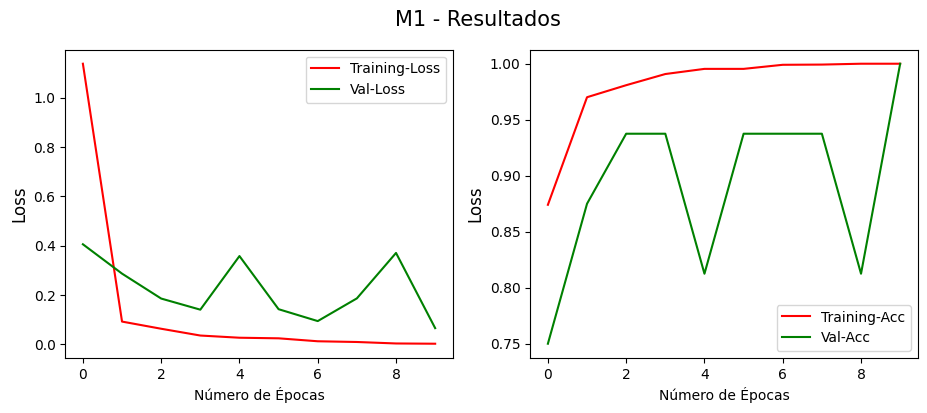

In [21]:
history_plot(hist_m1, 'M1 - Resultados')